In [21]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [10]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25
time_int = 60 # time in minutes to build volume candles on
atr_periods = 80

In [11]:
contract = contract.loc['20180102':]
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-01-02 00:00:00,2675.25,2677.00,2674.50,2676.75,2939,2675.700,491
2018-01-02 00:01:00,2676.75,2678.00,2676.50,2678.00,1258,2677.450,206
2018-01-02 00:02:00,2678.00,2678.75,2677.50,2678.50,852,2678.200,119
2018-01-02 00:03:00,2678.50,2678.75,2678.00,2678.25,547,2678.300,99
2018-01-02 00:04:00,2678.25,2678.50,2678.00,2678.50,275,2678.200,66
...,...,...,...,...,...,...,...
2019-09-05 08:51:00,2957.50,2957.75,2957.50,2957.50,361,2957.525,70
2019-09-05 08:52:00,2957.50,2958.00,2957.00,2957.25,517,2957.575,112
2019-09-05 08:53:00,2957.50,2957.75,2957.25,2957.50,267,2957.400,85


In [12]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [14]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 09:53:00,2675.25,2681.75,2674.50,2678.00,11547,63485,7.250000
1,2018-01-02 14:02:00,2678.00,2684.75,2675.25,2684.00,10473,63689,8.389062
2,2018-01-02 15:29:00,2684.00,2688.25,2683.25,2687.00,6455,52664,7.231017
3,2018-01-02 15:39:00,2687.00,2687.25,2681.75,2685.75,7997,82174,6.781901
4,2018-01-02 15:58:00,2685.75,2687.00,2683.50,2686.50,6720,67696,6.092297
...,...,...,...,...,...,...,...,...
9500,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743,7.924526
9501,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663,7.944908
9502,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567,8.316639


In [15]:
periods = [5, 10, 20, 40, 80, 160, 320]

In [72]:
max_candles = pd.DataFrame({'close': vol_candles.close})
min_candles = pd.DataFrame({'close': vol_candles.close})
for period in periods:
    max_candles[period] = max_candles.close - max_candles.close.rolling(period).max()
    min_candles[period] = min_candles.close - min_candles.close.rolling(period).min()
max_candles['total_max'] = (sum([max_candles[i] for i in periods]) / len(periods)).rolling(100).mean() + 50
min_candles['total_min'] = ((sum([min_candles[i] for i in periods]) / len(periods)).rolling(100).mean() - 50)
total = max_candles['total_max'] - min_candles['total_min']
total

label
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
9500    36.735357
9501    36.817857
9502    36.703214
9503    36.561071
9504    36.430714
Length: 9505, dtype: float64

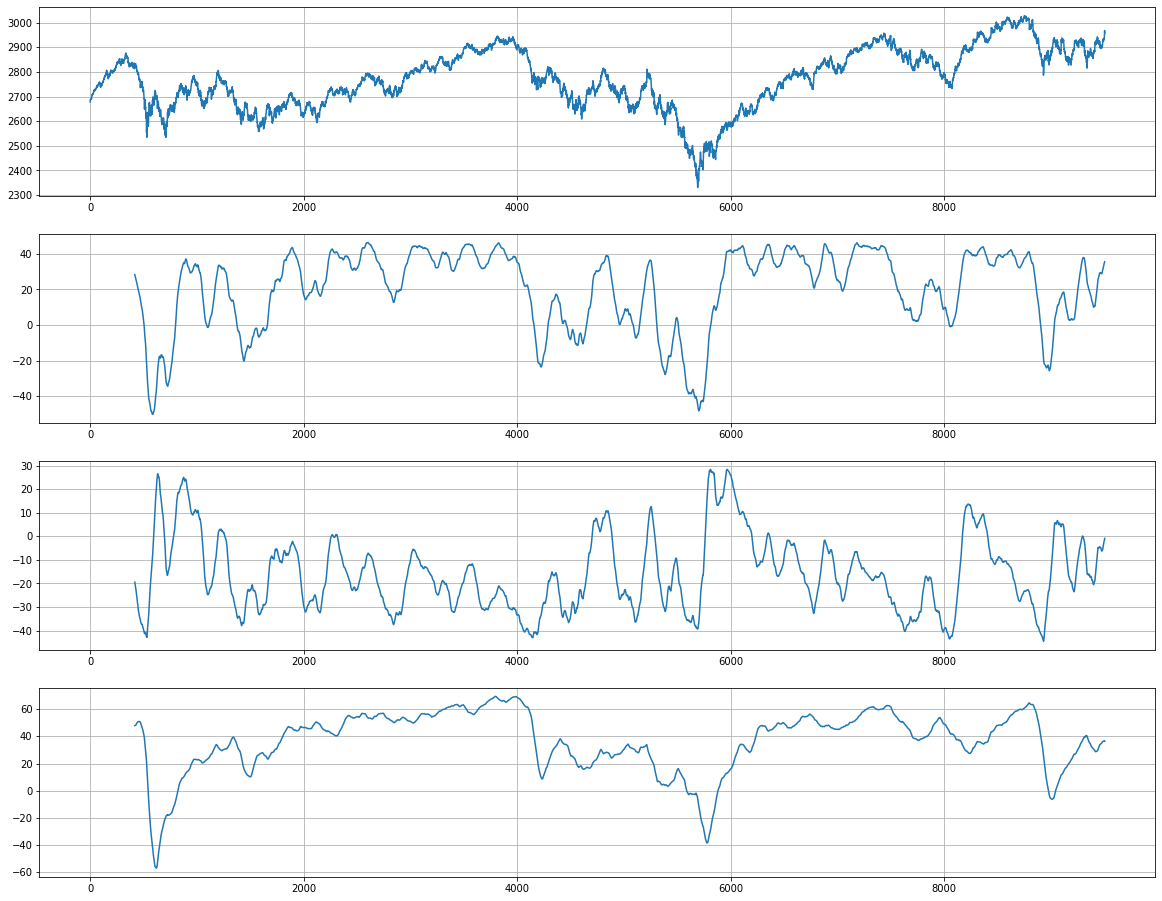

In [75]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(411)
ax.plot(max_candles['close'])
ax.grid()
ax1 = fig.add_subplot(412, sharex=ax)
ax1.plot(max_candles['total_max'])
ax1.grid()
ax2 = fig.add_subplot(413, sharex=ax)
ax2.plot(min_candles['total_min'])
ax2.grid()
ax3 = fig.add_subplot(414, sharex=ax)
ax3.plot(total)
ax3.grid()
plt.show();